In [3]:
import pickle

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error

In [4]:
pip list

Package                   Version
------------------------- --------------
anyio                     4.7.0
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 3.0.0
async-lru                 2.0.4
attrs                     24.2.0
babel                     2.16.0
beautifulsoup4            4.12.3
bleach                    6.2.0
certifi                   2024.8.30
cffi                      1.17.1
charset-normalizer        3.4.0
colorama                  0.4.6
comm                      0.2.2
contourpy                 1.3.1
cycler                    0.12.1
debugpy                   1.8.9
decorator                 5.1.1
defusedxml                0.7.1
executing                 2.1.0
fastjsonschema            2.21.1
filelock                  3.13.1
fonttools                 4.55.3
fqdn                      1.5.1
fsspec                    2024.2.0
gitdb                     4.0.11
GitPython                 3.1.43
h11       

In [5]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
    df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])

    # Calculate duration
    df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']

    # in seconds
    df['duration'] = df['duration'].dt.total_seconds() / 60

    # durations for more than 1 minute and less than 60 minutes
    df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]

    categorical = ['PULocationID', 'DOLocationID']

    df[categorical] = df[categorical].astype(str)
    
    df['PU_DO'] = df['PULocationID'] + '_' + df['DOLocationID']
    
    return df

In [6]:
pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


In [7]:
train_df = read_dataframe("./data/green_tripdata_2024-01.parquet")
test_df = read_dataframe("./data/green_tripdata_2024-02.parquet")

/tmp/ipykernel_26057/3015924380.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df['duration'])


<Axes: xlabel='duration', ylabel='Density'>

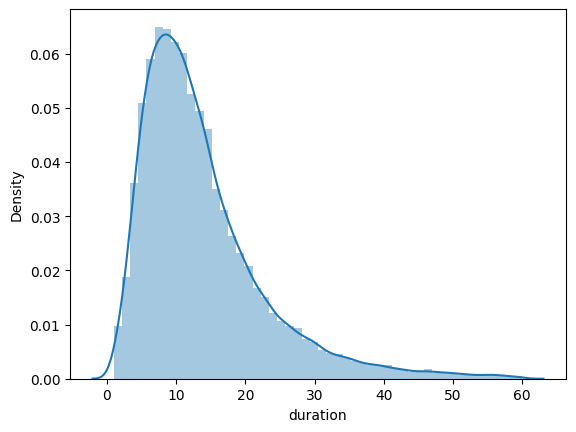

In [8]:
sns.distplot(train_df['duration'])

In [9]:
categorical = ['PU_DO']#['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

train_dict = train_df[categorical + numerical].to_dict(orient="records")
val_dicts = test_df[categorical + numerical].to_dict(orient="records")

dv = DictVectorizer()
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dicts)

target = 'duration'
y_train = train_df[target].values
y_val = test_df[target].values

In [10]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_pred = lr_model.predict(X_train)
y_pred = lr_model.predict(X_val)

print("train: ", mean_squared_error(y_train, y_train_pred) ** 1/2)
print("test: ", mean_squared_error(y_val, y_pred)** 1/2)

train:  11.615303015904797
test:  17.97026098083373


In [11]:
lr_model = Lasso()
lr_model.fit(X_train, y_train)

y_train_pred = lr_model.predict(X_train)
y_pred = lr_model.predict(X_val)

print("train: ", mean_squared_error(y_train, y_train_pred)** 1/2)
print("test: ", mean_squared_error(y_val, y_pred)** 1/2)

train:  40.67598657118138
test:  41.49915562846756


In [12]:
lr_model = Ridge()
lr_model.fit(X_train, y_train)

y_train_pred = lr_model.predict(X_train)
y_pred = lr_model.predict(X_val)

print("train: ", mean_squared_error(y_train, y_train_pred, squared=False))
print("test: ", mean_squared_error(y_val, y_pred, squared=False))

TypeError: got an unexpected keyword argument 'squared'

In [13]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

y_train_pred = xgb_model.predict(X_train)
y_pred = xgb_model.predict(X_val)

print("train: ", mean_squared_error(y_train, y_train_pred) ** 1/2 )
print("test: ", mean_squared_error(y_val, y_pred) ** 1/2 )

train:  12.821681538835476
test:  14.395057996666317


In [14]:
with open('models/xgb_model.bin', 'wb') as f_out:
    pickle.dump((dv, xgb_model), f_out)

In [15]:
pip freeze

anyio==4.7.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==3.0.0
async-lru==2.0.4
attrs==24.2.0
babel==2.16.0
beautifulsoup4==4.12.3
bleach==6.2.0
certifi==2024.8.30
cffi==1.17.1
charset-normalizer==3.4.0
colorama==0.4.6
comm==0.2.2
contourpy==1.3.1
cycler==0.12.1
debugpy==1.8.9
decorator==5.1.1
defusedxml==0.7.1
executing==2.1.0
fastjsonschema==2.21.1
filelock==3.13.1
fonttools==4.55.3
fqdn==1.5.1
fsspec==2024.2.0
gitdb==4.0.11
GitPython==3.1.43
h11==0.14.0
httpcore==1.0.7
httpx==0.28.1
idna==3.10
ipykernel==6.29.5
ipython==8.30.0
isoduration==20.11.0
jedi==0.19.2
Jinja2==3.1.4
joblib==1.4.2
json5==0.10.0
jsonpointer==3.0.0
jsonschema==4.23.0
jsonschema-specifications==2024.10.1
jupyter-events==0.10.0
jupyter-lsp==2.2.5
jupyter-server-mathjax==0.2.6
jupyter_client==8.6.3
jupyter_core==5.7.2
jupyter_server==2.14.2
jupyter_server_terminals==0.5.3
jupyterlab==4.3.3
jupyterlab_git==0.50.2
jupyterlab_pygments==0.3.0
jupyterlab_server==2.27.3
kiwisolver==1.4.7
Mar